In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
stops = set(stopwords.words("english"))

In [3]:
features = [
#     'clean_q1_tokenized',
#     'clean_q2_tokenized',
#     'clean_q1_stem',
#     'clean_q2_stem',
#     'clean_q1_pos_tagged',
#     'clean_q2_pos_tagged',
    'clean_q1_lemmatized',
    'clean_q2_lemmatized',
#     'clean_q1_lemmatized_stem',
#     'clean_q2_lemmatized_stem'
]

In [4]:
def read_data(t, features):
    data = pd.read_csv('../input/{}.csv'.format(t))
    for feature in features:
        data = pd.merge(data, pd.read_pickle('../feature/{}_{}.pkl'.format(t, feature)))
    data.fillna(0.0)
    return data

In [5]:
train = read_data('train', features)#[:10000]
test = read_data('test', features)#[:10000]

In [6]:
import gensim
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin.gz', binary=True)

2017-04-08 02:53:05,766 : INFO : loading projection weights from ../data/GoogleNews-vectors-negative300.bin.gz
2017-04-08 02:55:46,056 : INFO : loaded (3000000, 300) matrix from ../data/GoogleNews-vectors-negative300.bin.gz


In [7]:
def min_sim(row):
    q1_word = set(word for word in row.clean_q1_lemmatized if word not in stops and word in model)
    q2_word = set(word for word in row.clean_q2_lemmatized if word not in stops and word in model)
    and_word = q1_word & q2_word
    q1_word -= and_word
    q2_word -= and_word
    if len(q1_word) == 0 or len(q2_word) == 0:
        return 5
    return min(model.similarity(w1, w2) for w1 in q1_word for w2 in q2_word)

In [8]:
def max_sim(row):
    q1_word = set(word for word in row.clean_q1_lemmatized if word not in stops and word in model)
    q2_word = set(word for word in row.clean_q2_lemmatized if word not in stops and word in model)
    and_word = q1_word & q2_word
    q1_word -= and_word
    q2_word -= and_word
    if len(q1_word) == 0 or len(q2_word) == 0:
        return -5
    return max(model.similarity(w1, w2) for w1 in q1_word for w2 in q2_word)

In [9]:
train['min_sim'] = train.apply(min_sim, axis=1)
test['min_sim'] = test.apply(min_sim, axis=1)

In [10]:
train['max_sim'] = train.apply(max_sim, axis=1)
test['max_sim'] = test.apply(max_sim, axis=1)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 15.0)

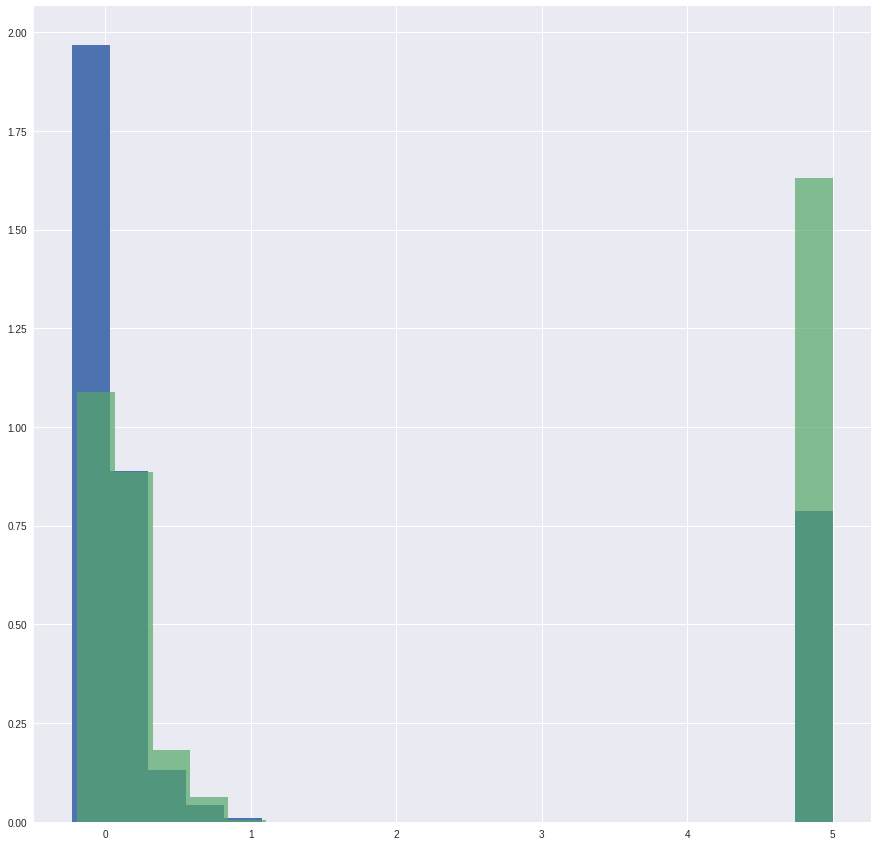

In [12]:
plt.hist(train.min_sim[train['is_duplicate'] == 0], bins=20, normed=True, label='0')
plt.hist(train.min_sim[train['is_duplicate'] == 1], bins=20, normed=True, label='1', alpha=0.7)
None

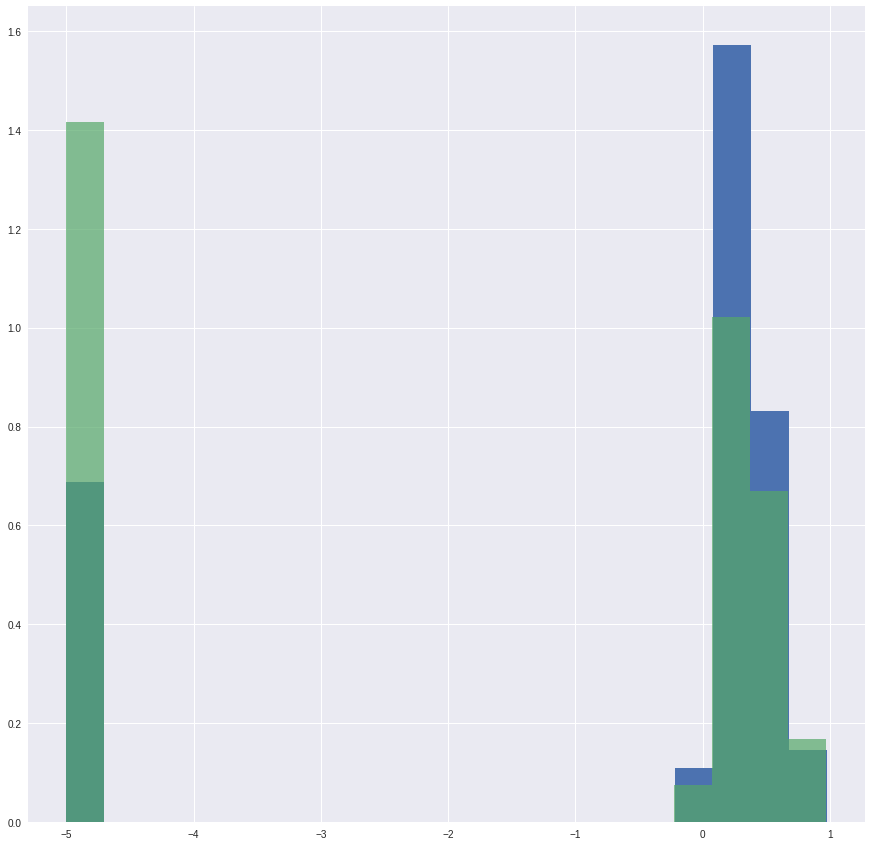

In [13]:
plt.hist(train.max_sim[train['is_duplicate'] == 0], bins=20, normed=True, label='0')
plt.hist(train.max_sim[train['is_duplicate'] == 1], bins=20, normed=True, label='1', alpha=0.7)
None

In [14]:
features_to_save = [
    'min_sim',
    'max_sim'
]

In [15]:
import util
util.save_feature(train, 'train', features_to_save, 'id')
util.save_feature(test, 'test', features_to_save, 'test_id')

In [16]:
train

,id,qid1,qid2,question1,question2,is_duplicate,clean_q1_lemmatized,clean_q2_lemmatized,min_sim,max_sim
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[what, be, the, step, by, step, guide, to, inv...","[what, be, the, step, by, step, guide, to, inv...",5.000000,-5.000000
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[what, be, the, story, of, kohinoor, koh, i, n...","[what, would, happen, if, the, indian, governm...",0.045586,0.146727
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increase, by, ...",0.051315,0.540757
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[why, be, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, 24, mat...",-0.035250,0.383001
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[which, one, dissolve, in, water, quickly, sug...","[which, fish, would, survive, in, salt, water]",0.017842,0.290538
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,"[astrology, i, be, a, capricorn, sun, cap, moo...","[i, be, a, triple, capricorn, sun, moon, and, ...",-0.006192,0.248316
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,"[should, i, buy, tiago]","[what, keep, childern, active, and, far, from,...",0.039961,0.247378
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,"[how, can, i, be, a, good, geologist]","[what, should, i, do, to, be, a, great, geolog...",0.729151,0.729151
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,"[when, do, you, use, instead, of]","[when, do, you, use, instead, of, and]",5.000000,-5.000000
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,"[motorola, company, can, i, hack, my, charter,...","[how, do, i, hack, motorola, dcx3400, for, fre...",0.050833,0.099374
